In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.cluster import GaussianCluster, AutoGMMCluster


In [2]:
!ln -s /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/notebooks/HSBM.py HSBM.py

usage: ln [-Ffhinsv] source_file [target_file]
       ln [-Ffhinsv] source_file ... target_dir
       link source_file target_file


In [3]:
from HSBM import RecursiveCluster

## synthetic Gaussian mixture data

### 1D 2GMM

In [4]:
def GM_line_init(center, length, cov_scale, n_sample, covariance_type="spherical"):
    
    gmm = GaussianMixture(n_components=2, covariance_type=covariance_type)
    gmm.fit(np.random.rand(3, 2))
    gmm.means_ = np.array([[center - length],[center + length]])
    gmm.covariances_ = np.repeat(cov_scale, 2)
    gmm.weights_ = np.array([1/2, 1/2])
    gmm.precisions_cholesky_ = 0
    x, _ = gmm.sample(n_sample)

    return x

In [5]:
def GM_line(cov_scale, n_level, n_sample):
    cov = 1
    length = 10
    center = 0
    x = GM_line_init(center=center, length=length, cov_scale=cov, n_sample=n_sample)
    x_pre = x
    for i in range(1, n_level):
        cov = cov * cov_scale
        length = length * cov_scale
        x_new = np.zeros((1,1))
        for j in range(len(x_pre)):
            center = x_pre[j][0]
            # print(center)
            x_post = GM_line_init(center=center, length=length, cov_scale=cov, n_sample=n_sample)
            x_new = np.append(x_new, x_post).reshape(-1,1)
        x_pre = x_new[1:, :]

    x_new = x_new[1:, :]

    return x_new

In [6]:
# np.random.seed(8888)
x = GM_line(0.3, 3, 4)
x.shape

(64, 1)

[]

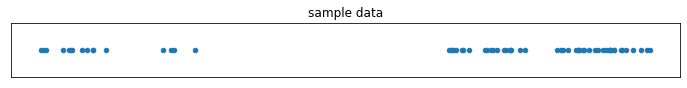

In [7]:
fig,ax = plt.subplots(1, figsize=(12,1))
ax.scatter(x, np.zeros(len(x)), s=20)
ax.set(title="sample data")
ax.set_xticks([]); ax.set_yticks([])

In [12]:
n_level = 3
label_true = np.zeros((x.shape[0], n_level))
for i in range(n_level):
    n_clus = 2 ** (i+1)
    for j in range(n_clus):
        label_true[j * x.shape[0]//n_clus:(j+1) * x.shape[0]//n_clus,i] = j

In [20]:
scales = np.linspace(0.1, 0.5, num=5)
n_sample = 20
ARIs_lvl1 = np.zeros((len(scales), n_sample, n_level))
n_comp = np.zeros((len(scales), n_sample))
for i in range(len(scales)):
    print("i = ", i)
    for j in range(n_sample):
        print("j =", j)
        x = GM_line(scales[i], 4, 2)
        agmm = AutoGMMCluster(min_components=1, max_components=10)
        labels = agmm.fit_predict(x.reshape(-1,1))
        n_comp[i,j] = np.max(labels) + 1
        for k in range(n_level):
            ARIs_lvl1[i,j,k] = adjusted_rand_score(label_true[:,k], labels)

i =  0
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
i =  1
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
i =  2
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
i =  3
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
i =  4
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19


In [8]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

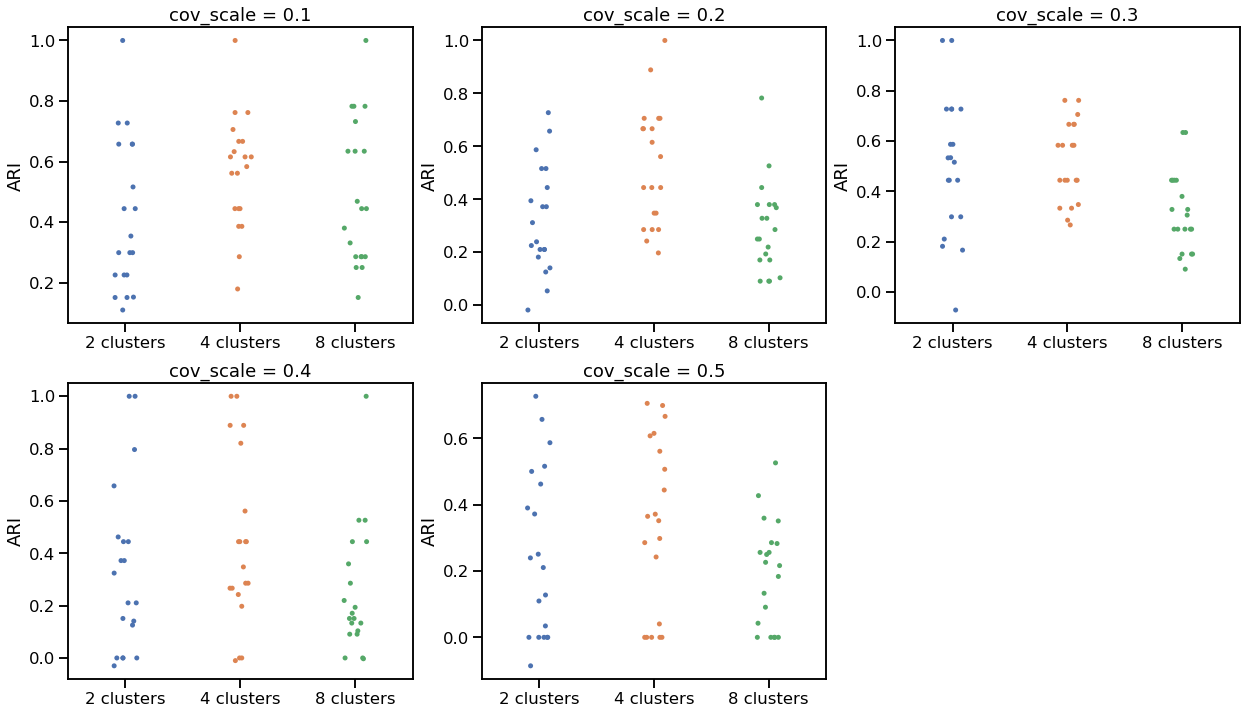

In [63]:
fig,axs = plt.subplots(2,3, figsize=(21,12))
idx = -1
for i in range(2):
    for j in range(3):
        idx += 1
        ax = axs[i,j]
        if idx < 5:
            df = pd.DataFrame(ARIs_lvl1[idx,:,:])
            df.columns = ["2 clusters", "4 clusters", "8 clusters"]
            df = df.melt(value_vars=["2 clusters", "4 clusters", "8 clusters"])
            df.columns = ["level", "ARI"]
            sns.stripplot(data=df, x="level", y="ARI", ax=ax, palette="deep")
            ax.set(title = "cov_scale = %.1f"%scales[idx], xlabel="")
        else:
            ax.axis('off') 


#### cov_scale = 0.3

In [39]:
# generate 100 samples

n_sample = 100
for i in range(n_sample):
    if i == 0:
        x = GM_line(0.3, 6, 2)
    else:
        x_new = GM_line(0.3, 6, 2)
        x = np.append(x, x_new, axis=1)


In [1]:
# generate true labels for each level

n_level = 5
label_true = np.zeros((x.shape[0], n_level))
for i in range(n_level):
    n_clus = 2 ** (i+1)
    for j in range(n_clus):
        label_true[j * 64//n_clus:(j+1) * 64//n_clus,i] = j

In [ ]:
K = 3
ARIs_all_scale_pt_3 = {}
for i in range(100):
    print("i =", i)
    for j in range(K):
        print("j =", j)
        rc = RecursiveCluster(min_components=1, max_components=7)
        labels = rc.fit_predict(x[:,i].reshape(-1,1))
        print("n_level =", labels.shape[1] - 1)
        ARIs = np.zeros(labels.shape[1] - 1)
        for k in range(labels.shape[1] - 1):
            ARIs[k] = adjusted_rand_score(label_true[:,k], labels.iloc[:,k+1])
        ARIs_all_scale_pt_3[i,j] = ARIs

In [157]:
df = pd.DataFrame(ARIs_all_scale_pt_3)
df

,0,1,2,3
0,0.487805,0.366063,0.653061,NaN
1,0.520061,NaN,NaN,NaN
2,0.111321,0.279730,0.379009,NaN
3,0.210858,0.317825,NaN,NaN
4,0.402977,0.431744,NaN,NaN
...,...,...,...,...
95,0.508977,0.448939,NaN,NaN
96,0.600558,0.346732,0.640000,NaN
97,0.358452,0.254888,NaN,NaN
98,0.293578,0.325294,NaN,NaN


In [158]:
df = pd.DataFrame(ARIs_all_scale_pt_3)
df.columns = ["1", "2", "3", "4"]
nans = np.zeros(4)
for i in range(df.shape[1]):
    nans[i] = 100 - df[str(i+1)].isna().sum()
nans

array([100.,  98.,  38.,   3.])

In [147]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

[Text(0.5, 1.0, 'cov_scale=0.3')]

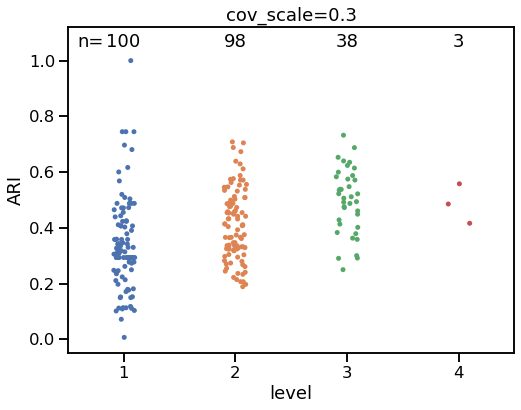

In [159]:
df = df.melt(value_vars=['1', '2', "3", "4"])
df.columns = ["level", "ARI"]
fig, ax = plt.subplots(1, figsize=(8,6))
sns.stripplot(data = df, x = "level", y = "ARI", ax=ax, palette="deep")
ax.set(ylim=(-0.05, 1.12))
ax.text(-0.3, 1.05, "n=", ha="center")
ax.text(0, 1.05, 100, ha="center")
ax.text(1, 1.05, 98, ha="center")
ax.text(2, 1.05, 38, ha="center")
ax.text(3, 1.05, 3, ha="center")
ax.set(title = "cov_scale=0.3")